### Check FLOPS and Parameters of Resnet and Q2 my designed shallow network

In [ ]:
from resnet34 import ResNet34
from model2 import Model2
from thop import profile, clever_format
import torch

model = ResNet34(num_classes=50)
model2 = Model2(num_classes=50)

In [14]:
dummy = torch.randn(1, 3, 256, 256)
flops, params = profile(model, inputs=(dummy,), verbose=False)
flops, params = clever_format([flops, params], "%.3f")
print(f'ResNet34:\nFLOPS:{flops}, Params:{params}')
dummy = torch.randn(1, 3, 256, 256)
flops, params = profile(model2, inputs=(dummy,), verbose=False)
flops, params = clever_format([flops, params], "%.3f")
print(f'My Designed Shallow Network:\nFLOPS:{flops}, Params:{params}')

ResNet34:
FLOPS:4.804G, Params:21.310M
My Designed Shallow Network:
FLOPS:2.146G, Params:225.458K


### Demonstrate the strategy of Q1

#### Observation of similar gray scale between different combinations of channels:

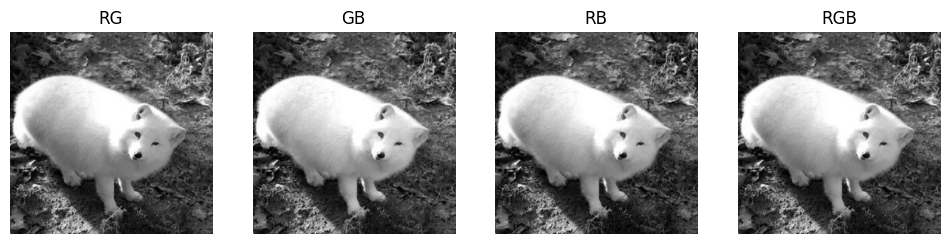

<Figure size 640x480 with 0 Axes>

In [7]:
from dataset import OrgDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataloader = DataLoader(OrgDataset('images', mode='test', size=(256, 256)), batch_size=1, shuffle=True, num_workers=0)
for i, (img, label) in enumerate(dataloader):
    rg = img[0][[0,1],:,:].numpy().sum(axis=0)/2
    gb = img[0][[1,2],:,:].numpy().sum(axis=0)/2
    rb = img[0][[0,2],:,:].numpy().sum(axis=0)/2
    rgb = img[0].numpy().sum(axis=0)/3
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 4, 1)
    plt.imshow(rg, cmap='gray')
    plt.axis('off')
    plt.title('RG')
    plt.subplot(1, 4, 2)
    plt.imshow(gb, cmap='gray')
    plt.axis('off')
    plt.title('GB')
    plt.subplot(1, 4, 3)
    plt.imshow(rb, cmap='gray')
    plt.axis('off')
    plt.title('RB')
    plt.subplot(1, 4, 4)
    plt.imshow(rgb, cmap='gray')
    plt.axis('off')
    plt.title('RGB')
    plt.show()
    plt.tight_layout()
    break

#### Preprocessing images:
#### arbitrary-channel image ==> gray ==> Contrast Limited Adaptive Histogram Equalization (CLAHE)/ Gamma Correction/ Lapacian Filter ==> Concat to get 3-channel image

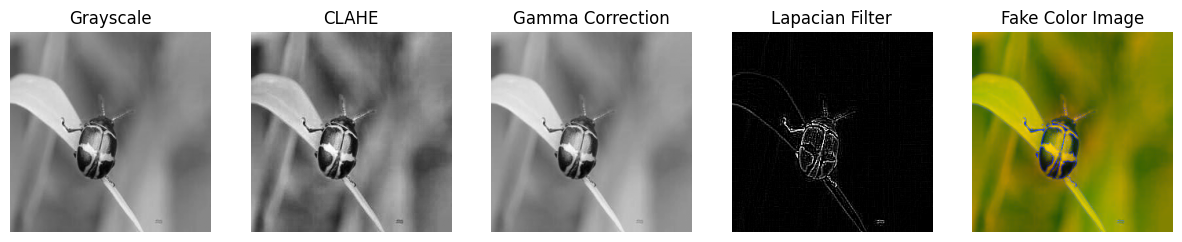

In [7]:
from dataset import MyDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

dataloader = DataLoader(MyDataset('images', mode='test', size=(256, 256), file_name=True), batch_size=1, shuffle=True, num_workers=0)
for i, (img, label, fn) in enumerate(dataloader):
    ch0 = img[0][0]
    ch1 = img[0][1]
    ch2 = img[0][2]
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 5, 1)
    org = Image.open(fn[0])
    org = org.resize((256, 256))
    org = np.array(org).mean(axis=2)
    plt.imshow(org, cmap='gray')
    plt.axis('off')
    plt.title('Grayscale')
    plt.subplot(1, 5, 2)
    plt.imshow(ch0, cmap='gray')
    plt.axis('off')
    plt.title('CLAHE')
    plt.subplot(1, 5, 3)
    plt.imshow(ch1, cmap='gray')
    plt.axis('off')
    plt.title('Gamma Correction')
    plt.subplot(1, 5, 4)
    plt.imshow(ch2, cmap='gray')
    plt.axis('off')
    plt.title('Lapacian Filter')
    plt.subplot(1, 5, 5)
    plt.imshow(img[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title('Fake Color Image')
    plt.show()
    break

### Testing the performance under different channels input.
#### Including RGB, RG, RB, GB, R, G, and B

In [21]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [22]:
from dataset import ChannelSelectDataset
from torch.utils.data import DataLoader
import torch
from resnet34 import ResNet34

class TestDiffChannels():
    def __init__(self, model, dataset, device=None, batch_size=1):
        self.model = model
        self.dataset = dataset
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
    
        self.model.eval().to(self.device)
        
    def set_channel_indices(self, channel_indices):
        if isinstance(channel_indices, int):
            channel_indices = [channel_indices]
        self.channel_indices = channel_indices
        self.dataloader = DataLoader(self.dataset('images', mode='test', size=(256, 256), channels=channel_indices), batch_size=self.batch_size, shuffle=False)

    def test_channel_accuracy(self, channel_indices = [0, 1, 2]):
        self.set_channel_indices(channel_indices)
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in self.dataloader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(images)
                _, predicted = torch.max(outputs, dim=1)

                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        return correct / total

In [ ]:
model = ResNet34(num_classes=50)
model.load_state_dict(torch.load('output/PreProcessing/20250420_010008/best_model.pth'))   
model.eval()
tester = TestDiffChannels(model, ChannelSelectDataset, batch_size=4)

In [ ]:
acc = tester.test_channel_accuracy([0, 1, 2])
print(f"Accuracy with RGB channels: {acc:.4f}")
acc = tester.test_channel_accuracy([0, 1])
print(f"Accuracy with RG channels: {acc:.4f}")
acc = tester.test_channel_accuracy([0, 2])
print(f"Accuracy with RB channels: {acc:.4f}")
acc = tester.test_channel_accuracy([1, 2])
print(f"Accuracy with GB channels: {acc:.4f}")
acc = tester.test_channel_accuracy([0])
print(f"Accuracy with R channels: {acc:.4f}")
acc = tester.test_channel_accuracy([1])
print(f"Accuracy with G channels: {acc:.4f}")
acc = tester.test_channel_accuracy([2])
print(f"Accuracy with B channels: {acc:.4f}")

Accuracy with RGB channels: 0.7044
Accuracy with RG channels: 0.6689
Accuracy with RB channels: 0.6889
Accuracy with GB channels: 0.6822
Accuracy with R channels: 0.6089
Accuracy with G channels: 0.6978
Accuracy with B channels: 0.6533
